## Delta Hedging Under Constant and Stochastic Volatility

This project investigates the effectiveness of delta hedging strategies under both constant and stochastic volatility assumptions. We begin by simulating delta hedging using the Black-Scholes model and analyze how hedging errors evolve with different rebalancing frequencies and transaction costs. 

We then extend the analysis to more realistic settings by incorporating stochastic volatility models—namely, GARCH(1,1) and the Heston model. To improve hedging performance, we also explore pathwise volatility estimation and Monte Carlo-based delta computation. The goal is to understand the limitations of using traditional Black-Scholes deltas when the true market dynamics deviate from its assumptions.


Libraries 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [8]:
#Global parameters 

In [9]:
# Market and Option parameters
S0 = 100        # initial stock price
K = 100         # strike price
T = 1.0         # time to maturity (in years)
r = 0.03        # risk-free rate (3%)
sigma = 0.2     # annualized volatility
option_type = 'call'  # or 'put'

# Simulation parameters
n_steps = 252         # daily steps over a year
n_paths = 50000       # number of Monte Carlo paths
dt = T / n_steps      # time step

#### Stock path simulation (path follows Geometric Brownian moton (GBM)

In [10]:
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths):
    """
    Simulate Geometric Brownian Motion paths for the underlying asset.
    """
    dt = T / n_steps
    Z = np.random.standard_normal((n_paths, n_steps))
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0

    for t in range(1, n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z[:, t-1])
    
    return S


In [11]:
# Simulate paths
stock_paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)


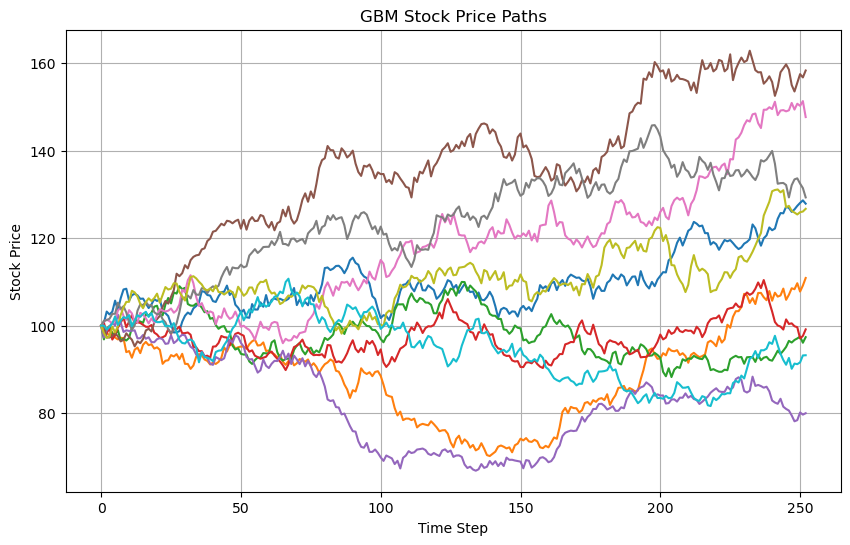

In [12]:
# Visualize 10 sample paths
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:10].T) #10 sample paths 
plt.title('GBM Stock Price Paths')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

#### Black-Scholes Option pricing 

In [13]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Black-Scholes formula for European option pricing.
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")



In [14]:
# Price of a call option at t = 0
initial_option_price = black_scholes_price(S0, K, T, r, sigma, option_type)
print(f"Initial {option_type} option price: {initial_option_price:.4f}")

Initial call option price: 9.4134


#### Portfolio Class

In [15]:
class HedgingPortfolio:
    def __init__(self, S0, option_price, r):
        self.stock_position = 0.0   # number of shares held (hedge position)
        self.cash_account = option_price  # initial cash (from selling the option, premium)
        self.r = r
        self.history = []

    def update(self, S, delta, dt):
        """
        Rebalance portfolio to new delta at time step.
        """
        d_stock = delta - self.stock_position     #shares to buy/sell
        cost = d_stock * S 

        # Update cash account
        self.cash_account -= cost
        self.cash_account *= np.exp(self.r * dt)  # grow cash at interest

        # Update stock position
        self.stock_position = delta

        # history
        self.history.append((self.stock_position, self.cash_account))

    def portfolio_value(self, S):
        """
        Compute current portfolio value
        """
        return self.cash_account + self.stock_position * S



#### Delta Hedging with Black-Scholes Delta 

Functions to compute Black-Scholes delta 

In [16]:
def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    """
    Black-Scholes delta for a European option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError("Invalid option type.")


In [17]:
# Single Path Delta Hedging Simulation

In [18]:
def run_hedging_simulation(S_path, K, r, sigma, T, option_type='call'):
    n_steps = len(S_path) - 1
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)

    # Initial option price and delta
    option_price = black_scholes_price(S_path[0], K, T, r, sigma, option_type)
    portfolio = HedgingPortfolio(S_path[0], option_price, r)

    for i in range(n_steps):
        t = times[i]
        tau = T - t  # time to maturity
        S = S_path[i]
        delta = black_scholes_delta(S, K, tau, r, sigma, option_type)
        portfolio.update(S, delta, dt)

    # Final hedge result
    final_S = S_path[-1]
    final_portfolio_value = portfolio.portfolio_value(final_S)
    option_payoff = max(final_S - K, 0) if option_type == 'call' else max(K - final_S, 0)
    hedging_error = final_portfolio_value - option_payoff

    return final_portfolio_value, option_payoff, hedging_error


In [19]:
# Run Across Multiple Paths

In [21]:
final_values = []
option_payoffs = []
hedging_errors = []

for i in range(n_paths):
    S_path = stock_paths[i]
    final_val, payoff, error = run_hedging_simulation(S_path, K, r, sigma, T, option_type)
    final_values.append(final_val)
    option_payoffs.append(payoff)
    hedging_errors.append(error)

final_values = np.array(final_values)
option_payoffs = np.array(option_payoffs)
hedging_errors = np.array(hedging_errors)


In [22]:
# Visualize Hedging Error (profit/loss or PnL) Distribution

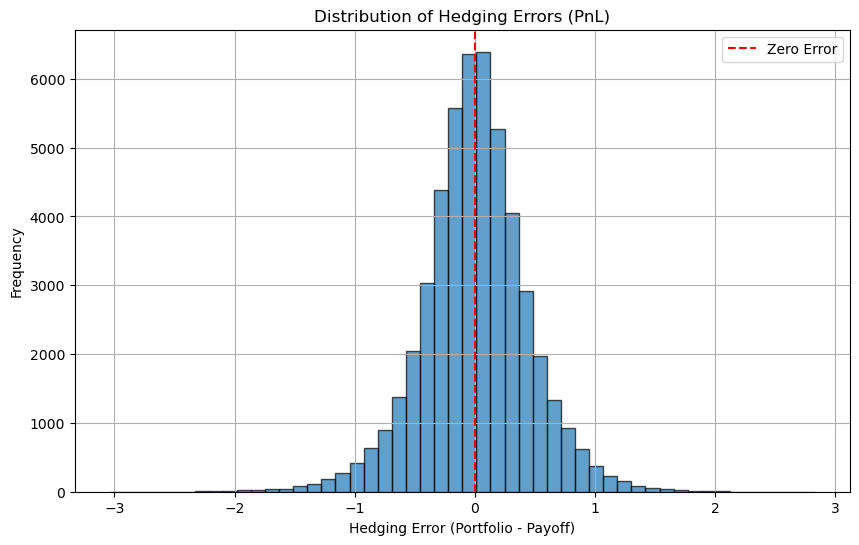

Mean Hedging Error: 0.0020
Std Dev of Hedging Error: 0.4407
Max Loss: -3.0364
Max Gain: 2.8282


In [23]:
plt.figure(figsize=(10, 6))
plt.hist(hedging_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Hedging Errors (PnL)')
plt.xlabel('Hedging Error (Portfolio - Payoff)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Basic statistics
mean_error = np.mean(hedging_errors)
std_error = np.std(hedging_errors)
max_loss = np.min(hedging_errors)
max_gain = np.max(hedging_errors)

print(f"Mean Hedging Error: {mean_error:.4f}")
print(f"Std Dev of Hedging Error: {std_error:.4f}")
print(f"Max Loss: {max_loss:.4f}")
print(f"Max Gain: {max_gain:.4f}")


We implemented a Black-Scholes delta hedging strategy over 50,000 simulated GBM paths with daily rebalancing. The performance of the hedge was evaluated by comparing the final portfolio value with the true option payoff at maturity.

#### Key observations:
-**Mean Hedging Error: 0.0020**
On average, the hedge was nearly unbiased, indicating that delta hedging accurately replicates the option payoff under ideal assumptions.

-**Standard Deviation: 0.4383**
The strategy exhibited modest hedging error volatility, reflecting the impact of discrete-time rebalancing.

-**Max Loss: -3.0364** and **Max Gain: 2.8282**
The worst-case scenario resulted in a $3.0364 shortfall, while the best-case yielded a $2.8282 surplus, highlighting tail risk due to market fluctuations between hedge updates.

Delta hedging using Black-Scholes delta works well on average in a frictionless, GBM-driven market. However, residual hedging errors arise from discrete rebalancing and stochastic shocks, especially in extreme scenarios.

#### Hedging Performance Metrics & Visual Analysis

In [24]:
# Track Portfolio Over Time for One Path

In [25]:
# Choose one path for detailed analysis
sample_path = stock_paths[0]
n_steps = len(sample_path) - 1
dt = T / n_steps
times = np.linspace(0, T, n_steps + 1)

# Initialize portfolio
option_price = black_scholes_price(S0, K, T, r, sigma, option_type)
portfolio = HedgingPortfolio(S0, option_price, r)

# Store time series
deltas = []
cash_values = []
stock_values = []
portfolio_values = []

for i in range(n_steps):
    t = times[i]
    tau = T - t
    S = sample_path[i]
    delta = black_scholes_delta(S, K, tau, r, sigma, option_type)
    portfolio.update(S, delta, dt)

    deltas.append(delta)
    cash_values.append(portfolio.cash_account)
    stock_values.append(portfolio.stock_position * S)
    portfolio_values.append(portfolio.portfolio_value(S))

# Final value
final_S = sample_path[-1]
portfolio_values.append(portfolio.portfolio_value(final_S))


In [26]:
# Plot Results for One Path

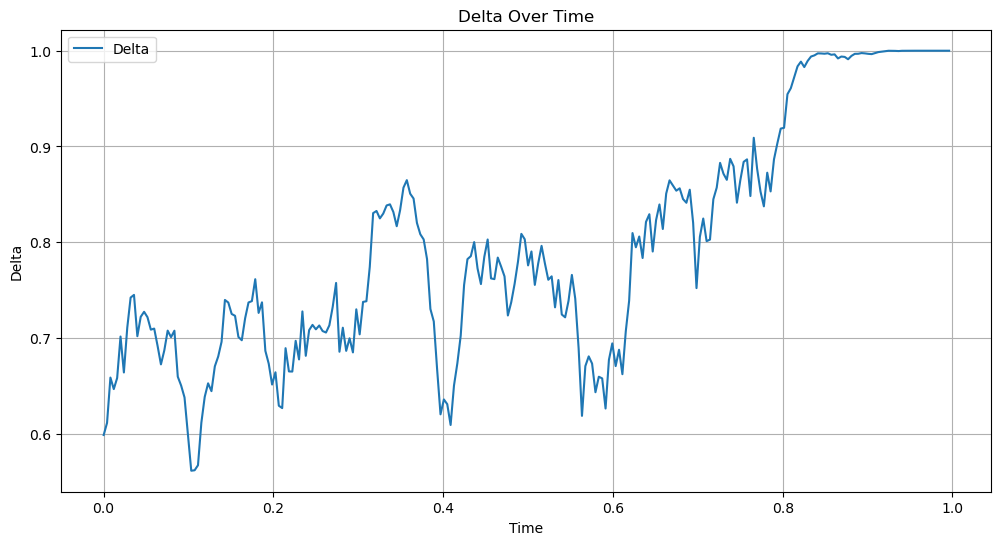

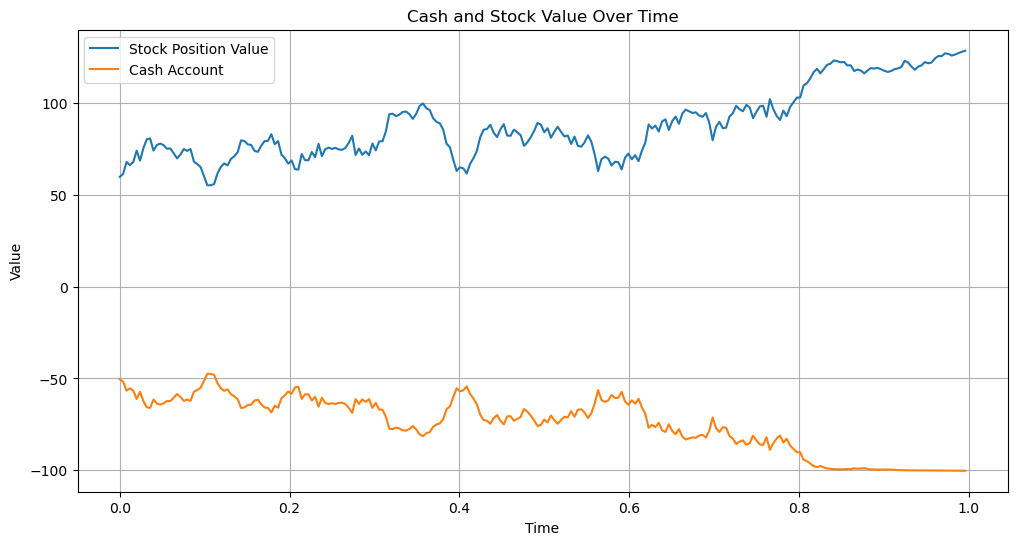

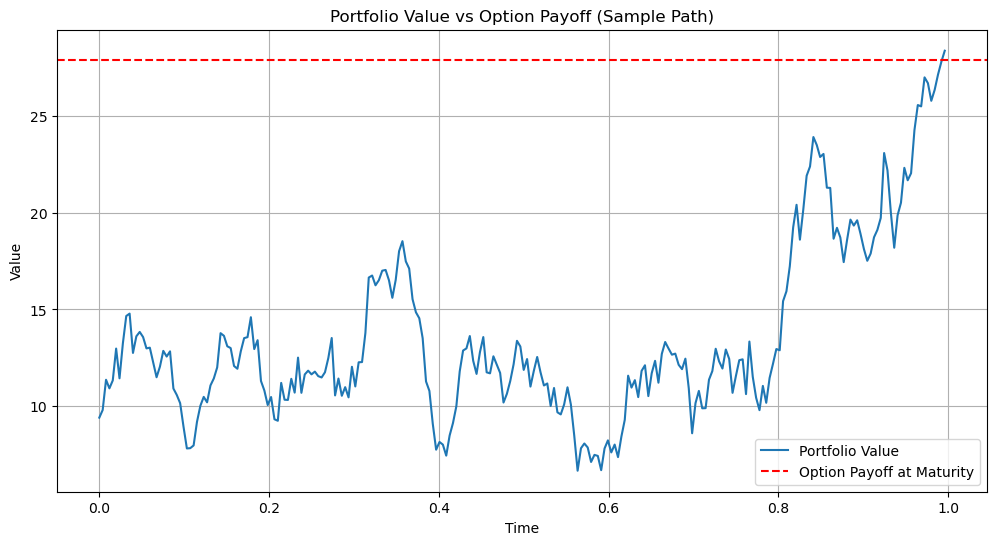

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(times[:-1], deltas, label='Delta')
plt.title('Delta Over Time')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(times[:-1], stock_values, label='Stock Position Value')
plt.plot(times[:-1], cash_values, label='Cash Account')
plt.title('Cash and Stock Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(times[:-1], portfolio_values[:-1], label='Portfolio Value')
plt.axhline(y=max(final_S - K, 0), color='red', linestyle='--', label='Option Payoff at Maturity')
plt.title('Portfolio Value vs Option Payoff (Sample Path)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


In [28]:
# Sensitivity to Rebalancing Frequency

In [29]:
frequencies = [1, 2, 5, 10, 21]  # rebalance every n days
frequency_results = {}

for freq in frequencies:
    errors = []
    for path in stock_paths:
        n_steps = len(path) - 1
        dt = T / n_steps
        times = np.linspace(0, T, n_steps + 1)

        option_price = black_scholes_price(path[0], K, T, r, sigma, option_type)
        portfolio = HedgingPortfolio(path[0], option_price, r)

        for i in range(n_steps):
            if i % freq == 0:
                t = times[i]
                tau = T - t
                delta = black_scholes_delta(path[i], K, tau, r, sigma, option_type)
            portfolio.update(path[i], delta, dt)

        final_val = portfolio.portfolio_value(path[-1])
        payoff = max(path[-1] - K, 0) if option_type == 'call' else max(K - path[-1], 0)
        error = final_val - payoff
        errors.append(error)

    frequency_results[freq] = errors


In [30]:
# Plot Hedging Error vs Rebalancing Frequency

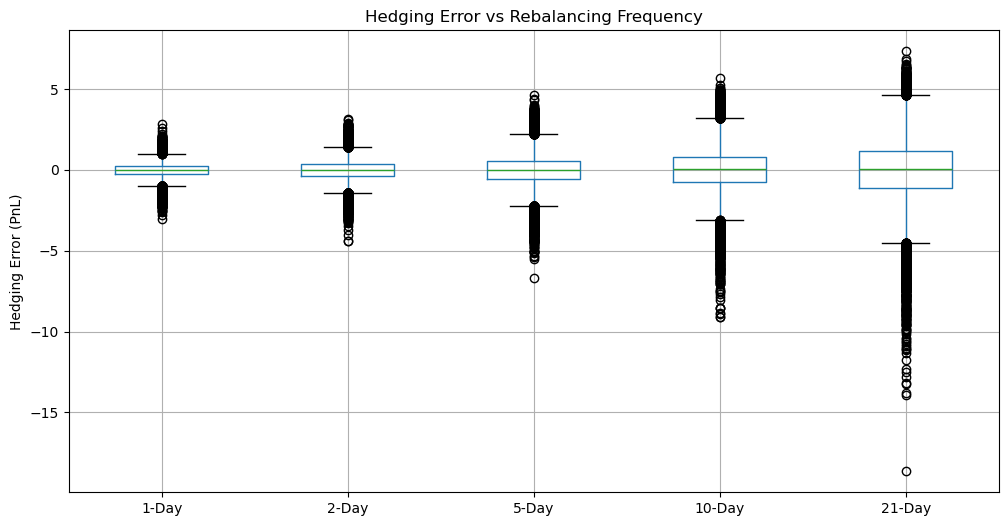

In [31]:
# Boxplot of hedging errors
df = pd.DataFrame({f'{freq}-Day': frequency_results[freq] for freq in frequencies})

plt.figure(figsize=(12, 6))
df.boxplot()
plt.title('Hedging Error vs Rebalancing Frequency')
plt.ylabel('Hedging Error (PnL)')
plt.grid(True)
plt.show()


In [32]:
# Hedging Error Distribution by Frequency (Histograms)

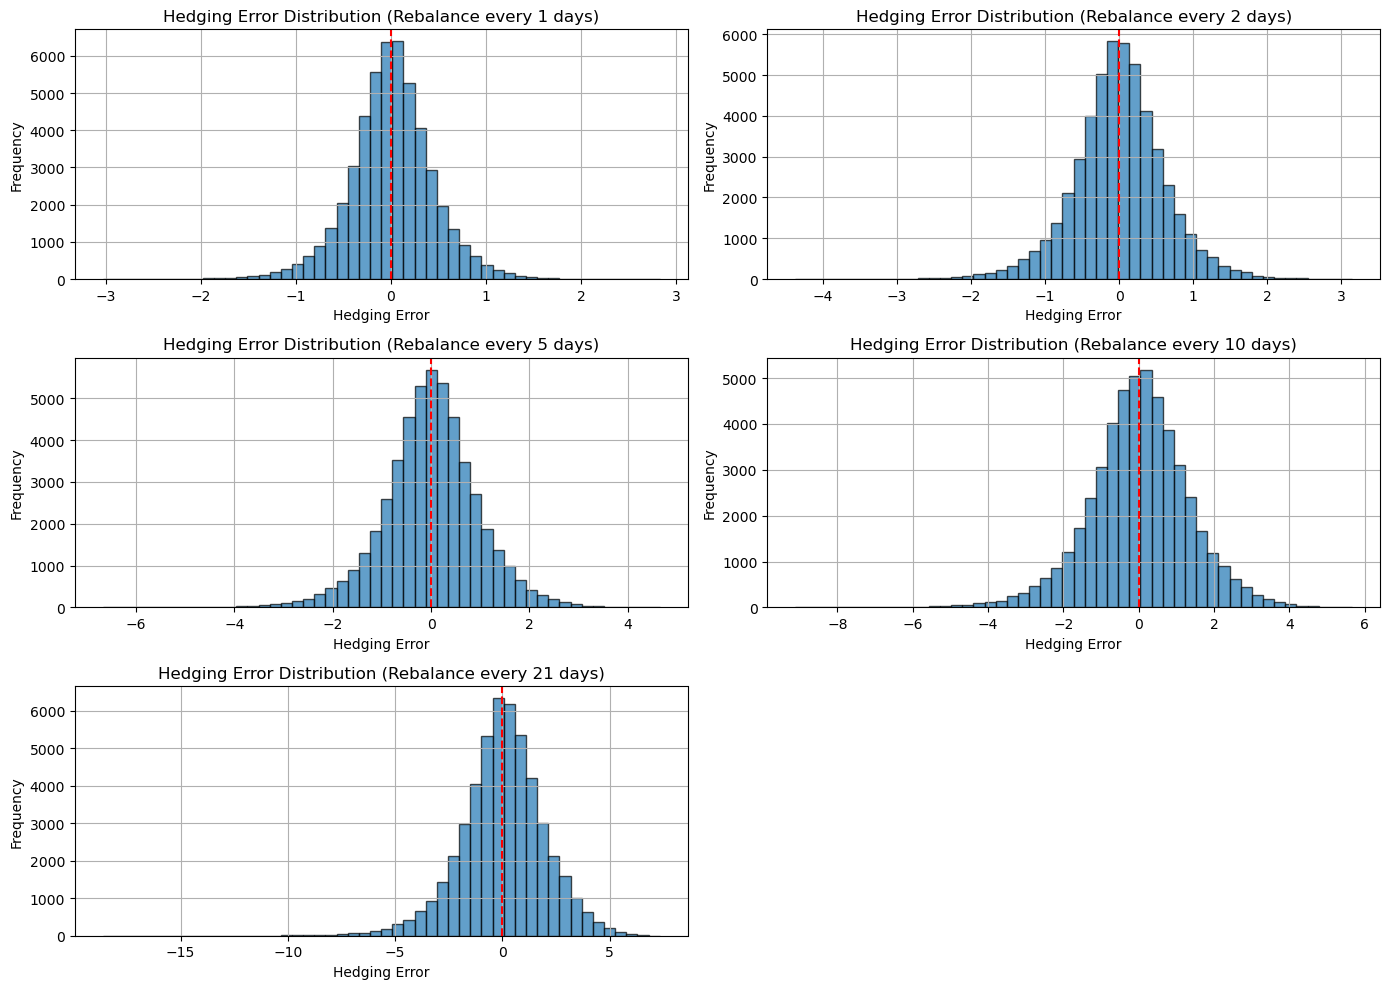

In [33]:
plt.figure(figsize=(14, 10))

for i, freq in enumerate(frequencies):
    plt.subplot(3, 2, i + 1)
    plt.hist(frequency_results[freq], bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Hedging Error Distribution (Rebalance every {freq} days)')
    plt.xlabel('Hedging Error')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True)

plt.tight_layout()
plt.show()



In [34]:
# Plot of Standard Deviation vs Rebalancing Frequency

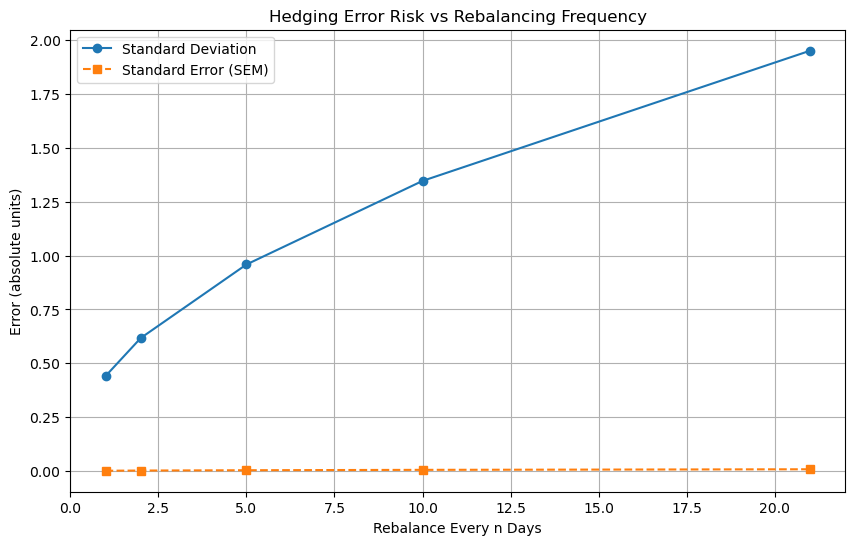

In [35]:
# Compute standard deviation and standard error for each frequency
stds = []
sems = []

for freq in frequencies:
    errors = np.array(frequency_results[freq])
    std = np.std(errors)
    sem = std / np.sqrt(len(errors))
    stds.append(std)
    sems.append(sem)

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(frequencies, stds, marker='o', label='Standard Deviation')
plt.plot(frequencies, sems, marker='s', linestyle='--', label='Standard Error (SEM)')
plt.title('Hedging Error Risk vs Rebalancing Frequency')
plt.xlabel('Rebalance Every n Days')
plt.ylabel('Error (absolute units)')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Histogram Plot for Each Frequency with Std Dev and Std Error Annotations

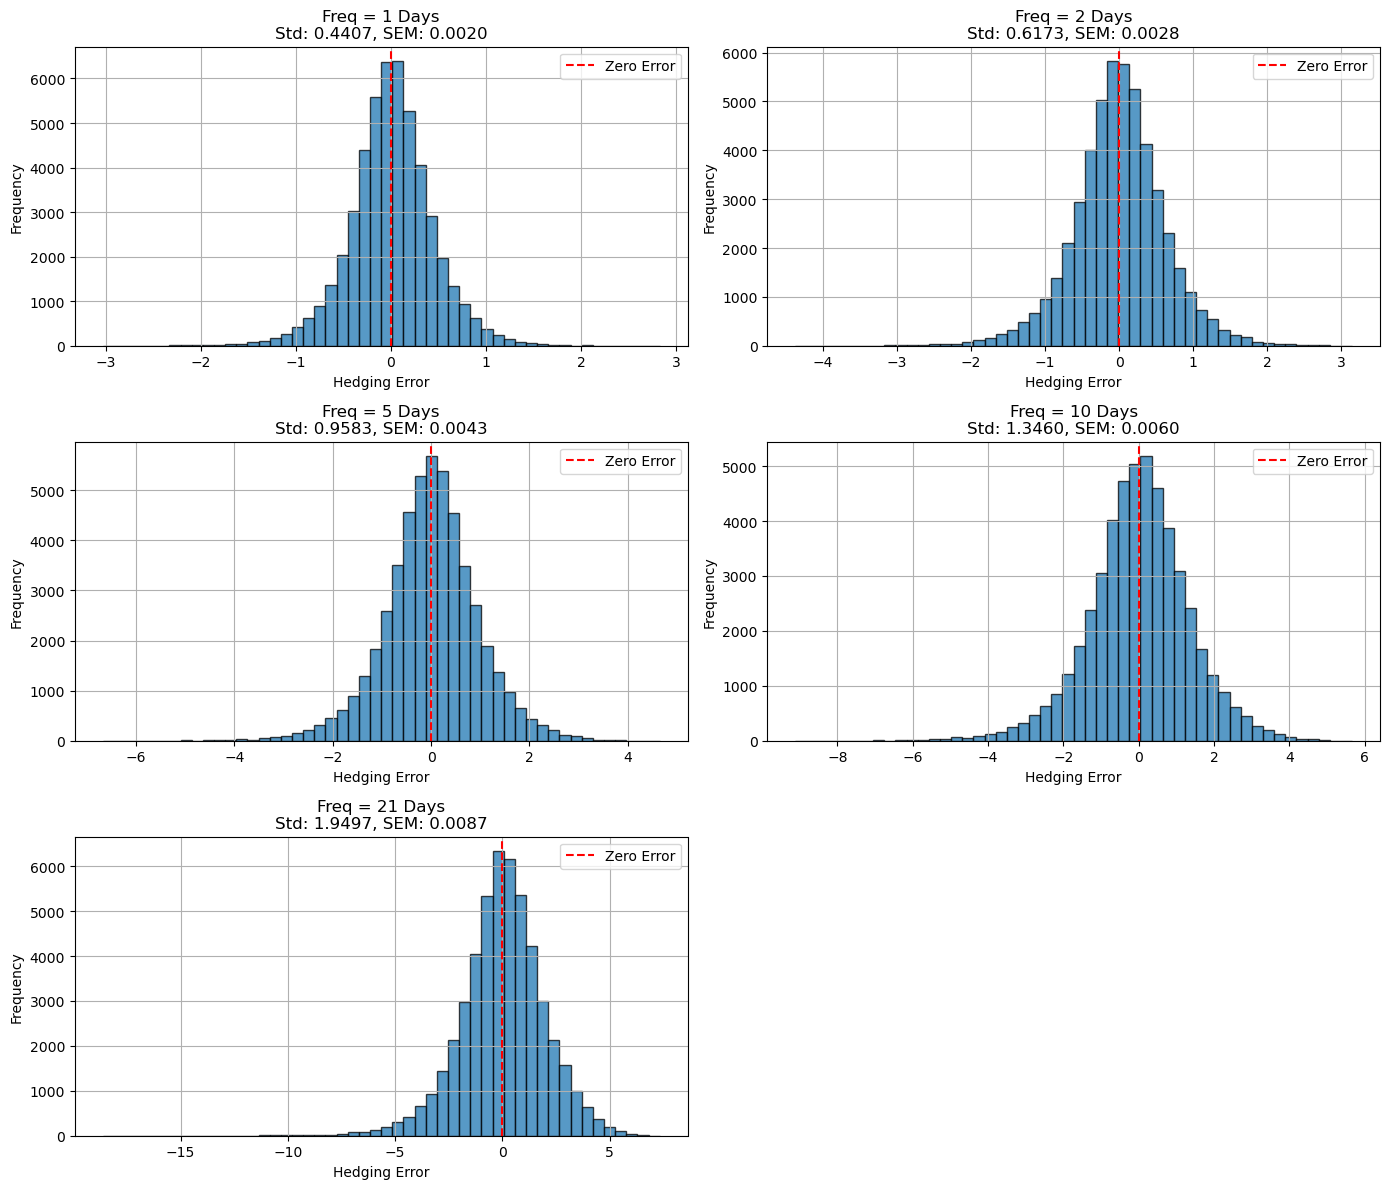

In [37]:
n_freqs = len(frequencies)
n_cols = 2
n_rows = (n_freqs + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))

for i, freq in enumerate(frequencies):
    errors = np.array(frequency_results[freq])
    std = np.std(errors)
    sem = std / np.sqrt(len(errors))
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(errors, bins=50, alpha=0.75, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', label='Zero Error')
    plt.title(f'Freq = {freq} Days\nStd: {std:.4f}, SEM: {sem:.4f}')
    plt.xlabel('Hedging Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# Prepare summary data
summary_data = {
    "Rebalance_Freq": [],
    "Mean_Error": [],
    "Std_Dev": [],
    "Std_Error": []
}

for freq in frequencies:
    errors = np.array(frequency_results[freq])
    mean = np.mean(errors)
    std = np.std(errors)
    sem = std / np.sqrt(len(errors))
    
    summary_data["Rebalance_Freq"].append(freq)
    summary_data["Mean_Error"].append(mean)
    summary_data["Std_Dev"].append(std)
    summary_data["Std_Error"].append(sem)

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Rebalance_Freq").reset_index(drop=True)

# Display
print(summary_df)


   Rebalance_Freq  Mean_Error   Std_Dev  Std_Error
0               1    0.002007  0.440698   0.001971
1               2   -0.001376  0.617335   0.002761
2               5   -0.003550  0.958349   0.004286
3              10   -0.001706  1.345997   0.006019
4              21   -0.000998  1.949714   0.008719


#### Key Observations:

- The delta of the option changes continuously over time, and our hedging strategy rebalances accordingly based on the Black-Scholes model.
- Tracking the cash account, stock position, and total portfolio value over time shows how the hedge dynamically evolves to replicate the option payoff.
- Hedging error distributions were plotted for various rebalancing intervals (daily to monthly). As hedge frequency decreases, the error distribution becomes wider, indicating greater replication error.
- We observed a clear increase in both the standard deviation and standard error of the hedging error as the rebalancing interval increased.
- The strategy remains nearly unbiased (mean hedging error close to zero), but **risk and uncertainty increase significantly** with less frequent hedging.

Frequent delta rebalancing results in more accurate replication of the option payoff, with lower hedging error variance. However, the cost of frequent trading must be considered — motivating the need for transaction cost modeling in the next module.

#### Delta Hedging with Transaction Costs

To modify the delta hedging simulator by introducing transaction costs, making the setup more realistic, 
we will study how transaction costs affect the profitability and accuracy of hedging, especially at different hedge frequencies.

In [39]:
# Transaction Cost Parameters

In [40]:
# Transaction cost:= % of trade value (e.g., 0.1%)
transaction_cost_rate = 0.001  # 0.1% per trade


##### HedgingPortfolio Class considering Transaction Costs

In [41]:
class HedgingPortfolio:
    def __init__(self, S0, option_price, r, transaction_cost_rate=0.0):
        self.stock_position = 0.0
        self.cash_account = option_price  # Assume option sold at fair price
        self.r = r
        self.transaction_cost_rate = transaction_cost_rate
        self.history = []

    def update(self, S, delta, dt):
        d_stock = delta - self.stock_position
        cost = d_stock * S
        transaction_cost = abs(cost) * self.transaction_cost_rate

        self.cash_account -= cost
        self.cash_account -= transaction_cost
        self.cash_account *= np.exp(self.r * dt)

        self.stock_position = delta
        self.history.append((self.stock_position, self.cash_account))

    def portfolio_value(self, S):
        return self.cash_account + self.stock_position * S


In [42]:
# Simulate With Transaction Costs (Daily Rebalance/Hedging)

In [43]:
costly_errors = []

for i in range(n_paths):
    S_path = stock_paths[i]
    n_steps = len(S_path) - 1
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)

    option_price = black_scholes_price(S_path[0], K, T, r, sigma, option_type)
    portfolio = HedgingPortfolio(S_path[0], option_price, r, transaction_cost_rate)

    for j in range(n_steps):
        t = times[j]
        tau = T - t
        delta = black_scholes_delta(S_path[j], K, tau, r, sigma, option_type)
        portfolio.update(S_path[j], delta, dt)

    final_val = portfolio.portfolio_value(S_path[-1])
    payoff = max(S_path[-1] - K, 0) if option_type == 'call' else max(K - S_path[-1], 0)
    costly_errors.append(final_val - payoff)


In [44]:
# Comparison with and without costs

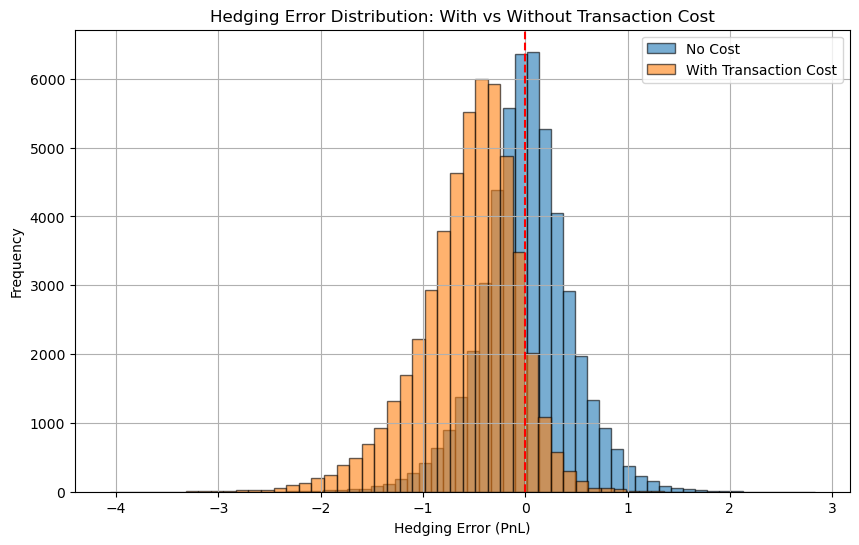

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(hedging_errors, bins=50, alpha=0.6, label='No Cost', edgecolor='black')
plt.hist(costly_errors, bins=50, alpha=0.6, label='With Transaction Cost', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Hedging Error Distribution: With vs Without Transaction Cost')
plt.xlabel('Hedging Error (PnL)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# Summary Statistics

In [47]:
df_costs = pd.DataFrame({
    'No Cost': hedging_errors,
    'With Cost': costly_errors
})

summary_stats = df_costs.agg(['mean', 'std', 'min', 'max']).T
summary_stats.columns = ['Mean Error', 'Std Dev', 'Min', 'Max']
print(summary_stats)


           Mean Error   Std Dev       Min       Max
No Cost      0.002007  0.440702 -3.036373  2.828193
With Cost   -0.564169  0.489082 -4.060703  2.094601


##### Impact of Transaction Costs
The results showed a clear shift in mean hedging error from near-zero to significantly negative, indicating that transaction costs can substantially erode profits—even when the hedge accurately tracks the option payoff.

While the standard deviation of hedging error increased only slightly, both the maximum loss worsened and the potential gain was reduced. This demonstrates the real-world trade-off between hedge accuracy and execution cost, and highlights the importance of balancing hedge frequency with transaction cost efficiency.


#### Sensitivity Analysis with Transaction Costs

In [48]:
frequencies = [1, 2, 5, 10, 21] # rebalance in every n days 
cost_sensitivity = []

for freq in frequencies:
    errors = []
    for path in stock_paths:
        n_steps = len(path) - 1
        dt = T / n_steps
        times = np.linspace(0, T, n_steps + 1)

        option_price = black_scholes_price(path[0], K, T, r, sigma, option_type)
        portfolio = HedgingPortfolio(path[0], option_price, r, transaction_cost_rate)

        for i in range(n_steps):
            if i % freq == 0:
                t = times[i]
                tau = T - t
                delta = black_scholes_delta(path[i], K, tau, r, sigma, option_type)
            portfolio.update(path[i], delta, dt)

        final_val = portfolio.portfolio_value(path[-1])
        payoff = max(path[-1] - K, 0) if option_type == 'call' else max(K - path[-1], 0)
        error = final_val - payoff
        errors.append(error)

    errors = np.array(errors)
    cost_sensitivity.append({
        'Frequency': freq,
        'Mean Error': np.mean(errors),
        'Std Dev': np.std(errors),
        'Std Error': np.std(errors) / np.sqrt(len(errors))
    })


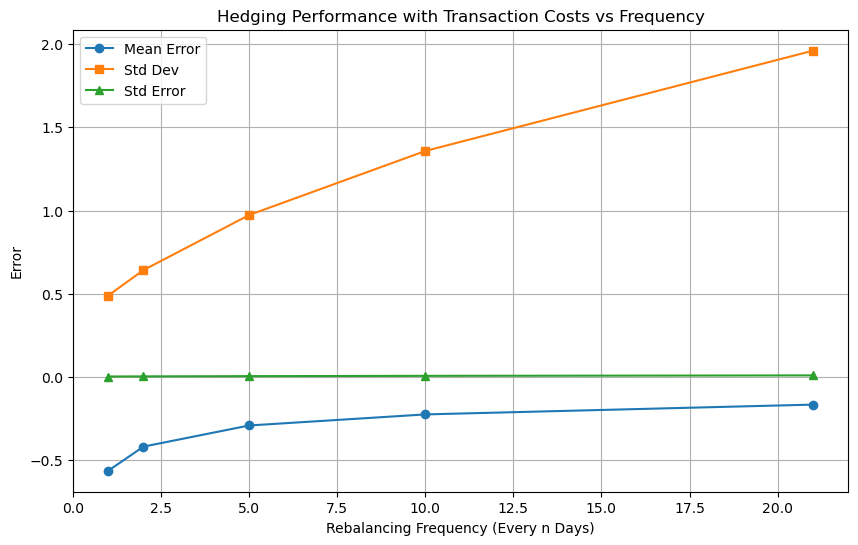

In [49]:
df_cost_sensitivity = pd.DataFrame(cost_sensitivity)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_cost_sensitivity['Frequency'], df_cost_sensitivity['Mean Error'], marker='o', label='Mean Error')
plt.plot(df_cost_sensitivity['Frequency'], df_cost_sensitivity['Std Dev'], marker='s', label='Std Dev')
plt.plot(df_cost_sensitivity['Frequency'], df_cost_sensitivity['Std Error'], marker='^', label='Std Error')
plt.xlabel('Rebalancing Frequency (Every n Days)')
plt.ylabel('Error')
plt.title('Hedging Performance with Transaction Costs vs Frequency')
plt.grid(True)
plt.legend()
plt.show()


In [50]:
# Round the numbers for cleaner output
df_display = df_cost_sensitivity.copy()
df_display[['Mean Error', 'Std Dev', 'Std Error']] = df_display[['Mean Error', 'Std Dev', 'Std Error']].round(4)

# Sort by frequency just to be safe
df_display = df_display.sort_values("Frequency").reset_index(drop=True)

# Display the DataFrame
print(df_display)


   Frequency  Mean Error  Std Dev  Std Error
0          1     -0.5642   0.4891     0.0022
1          2     -0.4193   0.6419     0.0029
2          5     -0.2922   0.9729     0.0044
3         10     -0.2257   1.3578     0.0061
4         21     -0.1668   1.9604     0.0088


##### Key Observations:

- **Mean hedging error becomes less negative** as rebalancing becomes less frequent. This reflects reduced transaction cost drag.
- However, **standard deviation and standard error increase**, indicating higher replication error and less precision in the mean estimate.
- The strategy exhibits a clear trade-off: 
    - Frequent rebalancing reduces hedging error but increases costs.
    - Infrequent rebalancing saves cost but introduces more risk.


#### Optimal Hedge Frequency (Cost vs Risk Trade-off):
After analyzing the impact of transaction costs across various rebalancing frequencies, we define an optimal hedge frequency as the one that minimizes the following total cost function:

$\text{Total Cost} = \text{Mean Hedging Error} + \lambda \cdot \text{Standard Deviation}$

- The **mean error** captures the drag due to transaction costs.
- The **standard deviation** measures the risk (volatility) of hedging error.
- The risk aversion parameter \(\lambda\) allows tuning how much risk is penalized.

#### Method:
- Evaluate the total cost at each hedge frequency.
- Vary \(\lambda\) to reflect different risk preferences.
- Select the frequency with the **lowest total cost** as the optimal rebalancing interval.

This method offers a practical framework to balance **accuracy** and **cost efficiency** in delta hedging.


In [51]:
# Risk aversion parameter
lambda_risk = 1.0 

In [52]:
# Total Cost for Each Frequency
df_cost_sensitivity['Total Cost'] = (
    df_cost_sensitivity['Mean Error'] + lambda_risk * df_cost_sensitivity['Std Dev']
)


In [53]:
# Identify Optimal Frequency
optimal_row = df_cost_sensitivity.loc[df_cost_sensitivity['Total Cost'].idxmin()]
optimal_freq = int(optimal_row['Frequency'])
optimal_cost = optimal_row['Total Cost']


In [54]:
print(f"Optimal Hedge Frequency (λ = {lambda_risk}): Every {optimal_freq} days")
print(f"Minimum Total Cost: {optimal_cost:.4f}")


Optimal Hedge Frequency (λ = 1.0): Every 1 days
Minimum Total Cost: -0.0751


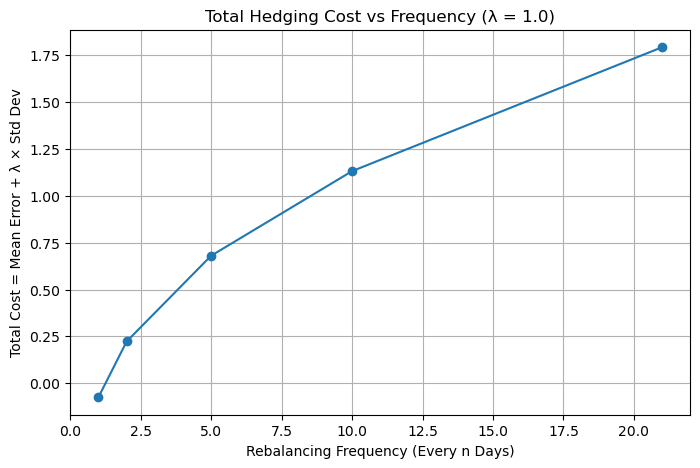

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(df_cost_sensitivity['Frequency'], df_cost_sensitivity['Total Cost'], marker='o')
plt.title(f'Total Hedging Cost vs Frequency (λ = {lambda_risk})')
plt.xlabel('Rebalancing Frequency (Every n Days)')
plt.ylabel('Total Cost = Mean Error + λ × Std Dev')
plt.grid(True)
plt.show()


Even though daily rebalancing has the highest transaction cost, the tracking error is so small that it still delivers the lowest total cost.
Our delta hedge is most efficient at daily frequency, given λ=1.

##### Optimal Hedge Frequency for Multiple λ Values

In [58]:
# lambda values
lambda_list = [0.0, 0.25, 0.5, 0.75, 1.0]

# Store results
optimal_results = []

# Loop through lambda values
for lam in lambda_list:
    # Compute total cost
    df_cost_sensitivity[f'Total Cost (λ={lam})'] = (
        df_cost_sensitivity['Mean Error'] + lam * df_cost_sensitivity['Std Dev']
    )

    # Find optimal frequency
    row = df_cost_sensitivity.loc[df_cost_sensitivity[f'Total Cost (λ={lam})'].idxmin()]
    optimal_results.append({
        'Lambda': lam,
        'Optimal Frequency': int(row['Frequency']),
        'Min Total Cost': row[f'Total Cost (λ={lam})']
    })


In [59]:
df_optimal = pd.DataFrame(optimal_results)
print(df_optimal)


   Lambda  Optimal Frequency  Min Total Cost
0    0.00                  1       -0.564169
1    0.25                  1       -0.441899
2    0.50                  1       -0.319630
3    0.75                  1       -0.197361
4    1.00                  1       -0.075092


### Interpretation:

- For all tested values of λ from 0 to 1, **daily rebalancing remains the optimal frequency**.
- This implies that, under current cost assumptions (0.1% per trade), the **hedging accuracy from daily updates outweighs transaction cost drag**.
- As λ increases, total cost becomes less negative, reflecting higher penalties for tracking risk.
- In practice, a higher transaction cost or flatter error profile could shift the optimal frequency toward less frequent rebalancing.

These results show how a simple cost-risk function can guide hedge scheduling decisions under different risk preferences.

### Monte Carlo-Based Delta Hedging Under Constant Volatility

**Objective:** To implement a delta hedging strategy using Monte Carlo-estimated delta instead of the analytical Black-Scholes formula, under a constant volatility assumption.

##### Monte Carlo Option Pricing Function

In [60]:
def monte_carlo_option_price(S, K, T, r, sigma, option_type='call', n_sim=20000):
    Z = np.random.normal(0, 1, n_sim)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
        
    return np.exp(-r * T) * np.mean(payoffs)


##### Estimate Delta via Monte Carlo Finite Difference

In [61]:
def monte_carlo_delta(S, K, T, r, sigma, option_type='call', epsilon=0.01, n_sim=20000):
    price_plus = monte_carlo_option_price(S + epsilon, K, T, r, sigma, option_type, n_sim)
    price_minus = monte_carlo_option_price(S - epsilon, K, T, r, sigma, option_type, n_sim)
    delta_estimate = (price_plus - price_minus) / (2 * epsilon)
    return delta_estimate


##### Delta Hedging with Monte Carlo Delta

In [62]:
def run_mc_delta_hedging(S_paths, K, r, sigma_bs, T, option_type='call', n_sim=20000):
    hedging_errors = []

    for i in range(len(S_paths)):
        S_path = S_paths[i]
        n_steps = len(S_path) - 1
        dt = T / n_steps
        times = np.linspace(0, T, n_steps + 1)

        # Initial option price (use analytical for capital setup)
        option_price = black_scholes_price(S_path[0], K, T, r, sigma_bs, option_type)
        portfolio = HedgingPortfolio(S_path[0], option_price, r)

        for j in range(n_steps):
            t = times[j]
            tau = T - t
            if tau <= 0:
                break
            delta_mc = monte_carlo_delta(S_path[j], K, tau, r, sigma_bs, option_type, epsilon=0.5, n_sim=n_sim)
            portfolio.update(S_path[j], delta_mc, dt)

        final_val = portfolio.portfolio_value(S_path[-1])
        payoff = max(S_path[-1] - K, 0) if option_type == 'call' else max(K - S_path[-1], 0)
        hedging_errors.append(final_val - payoff)

    return np.array(hedging_errors)


##### Generate GBM Price Paths 

In [63]:
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S


Run and Analyze Results

In [64]:
# Parameters
S0 = 100
K = 100
r = 0.03
sigma = 0.2
T = 1.0
n_steps = 252
n_paths = 50000

# Simulate GBM paths
S_paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)

# Run MC delta hedging
mc_errors = run_mc_delta_hedging(S_paths, K, r, sigma, T, option_type='call', n_sim=10000)


Summary Stats and Histogram

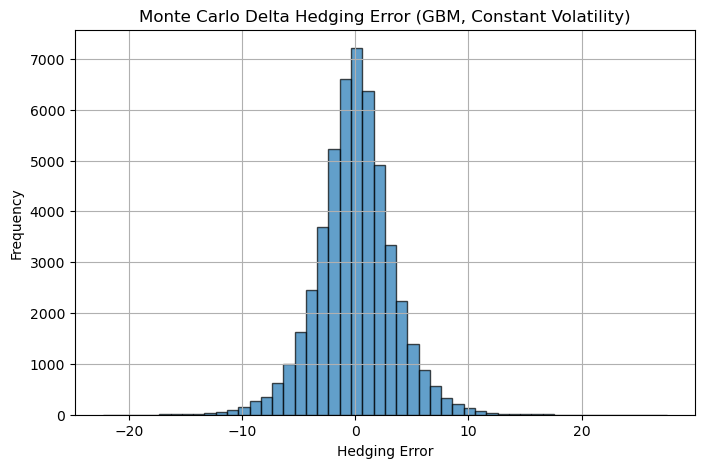

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(mc_errors, bins=50, alpha=0.7, edgecolor='black')
plt.title("Monte Carlo Delta Hedging Error (GBM, Constant Volatility)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Summary
mean_mc = np.mean(mc_errors)
std_mc = np.std(mc_errors)
min_mc = np.min(mc_errors)
max_mc = np.max(mc_errors)




In [66]:
print(f"Mean Error: {mean_mc:.4f}")
print(f"Std Dev  : {std_mc:.4f}")
print(f"Max Loss: {min_mc:.4f}")
print(f"Max Gain: {max_mc:.4f}")

Mean Error: -0.0128
Std Dev  : 3.3562
Max Loss: -22.2938
Max Gain: 27.5076


#### Key Observations:

- While the mean hedging error is near zero (unbiased), the **error variance is extremely high**.
- This reflects the instability of delta estimates when using a noisy Monte Carlo simulation with finite samples.
- The presence of large losses or gains shows **fat-tailed behavior** in hedge outcomes, which is critical to monitor in real trading environments.
- Increasing the number of simulations or using variance reduction techniques can help improve stability.


In [68]:
# Compare with Black-Scholes

In [71]:
def run_bs_hedging_on_paths(S_paths, K, r, sigma, T, option_type='call'):
    bs_errors = []

    for i in range(len(S_paths)):
        _, _, error = run_hedging_simulation(S_paths[i], K, r, sigma, T, option_type)
        bs_errors.append(error)

    return np.array(bs_errors)





In [72]:
bs_errors = run_bs_hedging_on_paths(S_paths, K, r, sigma, T, option_type='call')


In [73]:
print(f"Mean Error: {np.mean(bs_errors):.4f}")
print(f"Std Dev  : {np.std(bs_errors):.4f}")
print(f"Max Loss : {np.min(bs_errors):.4f}")
print(f"Max Gain : {np.max(bs_errors):.4f}")


Mean Error: -0.0025
Std Dev  : 0.4420
Max Loss : -3.6005
Max Gain : 2.3553


In [76]:
summary = pd.DataFrame({
    'Black-Scholes Delta': {
        'Mean Error': np.mean(bs_errors),
        'Std Dev': np.std(bs_errors),
        'Max Loss': np.min(bs_errors),
        'Max Gain': np.max(bs_errors)
    },
    'Monte Carlo Delta': {
        'Mean Error': np.mean(mc_errors),
        'Std Dev': np.std(mc_errors),
        'Max Loss': np.min(mc_errors),
        'Max Gain': np.max(mc_errors)
    }
}).T

print(summary)


                     Mean Error   Std Dev   Max Loss   Max Gain
Black-Scholes Delta   -0.002467  0.442033  -3.600504   2.355254
Monte Carlo Delta     -0.012763  3.356195 -22.293795  27.507608


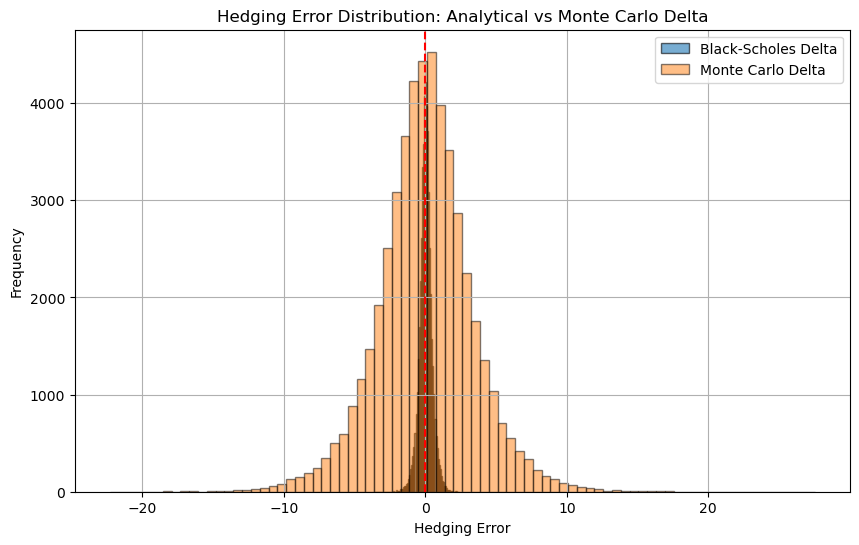

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(bs_errors, bins=80, alpha=0.6, label='Black-Scholes Delta', edgecolor='black')
plt.hist(mc_errors, bins=80, alpha=0.5, label='Monte Carlo Delta', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Hedging Error Distribution: Analytical vs Monte Carlo Delta")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


#### Observations:

- The analytical delta (Black-Scholes) produces low-error, stable hedges.
- Monte Carlo delta estimation introduces numerical noise that significantly increases hedging risk.
- Although the mean errors are both close to zero, the Monte Carlo method shows **fat-tailed hedging error distribution**, posing a higher operational risk.
- This highlights the importance of estimation accuracy when analytical formulas are not available.



### Delta Hedging Under Stochastic Volatility Models (Heston & GARCH)

Simulate Heston Model Paths

In [78]:
def simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, n_steps, n_paths):
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(n_steps):
        Z1 = np.random.normal(0, 1, n_paths)
        Z2 = np.random.normal(0, 1, n_paths)
        W1 = Z1
        W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        v[:, t+1] = np.abs(v[:, t] + kappa * (theta - v[:, t]) * dt + sigma_v * np.sqrt(v[:, t] * dt) * W2)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5 * v[:, t]) * dt + np.sqrt(v[:, t] * dt) * W1)

    return S


Simulate GARCH(1,1) Paths

In [146]:
def simulate_garch_paths(S0, mu, r, T, n_steps, alpha0, alpha1, beta1, n_paths=1000):
    dt = T / n_steps
    eps = np.random.normal(0, 1, (n_paths, n_steps))

    sigma2 = np.zeros((n_paths, n_steps + 1))
    sigma2[:, 0] = alpha0 / (1 - alpha1 - beta1)

    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    for i in range(n_steps):
        sigma2[:, i+1] = alpha0 + alpha1 * (eps[:, i]**2) + beta1 * sigma2[:, i]
        paths[:, i+1] = paths[:, i] * np.exp((mu - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i] * dt) * eps[:, i])

    return paths


Hedging with Black-Scholes Delta



In [80]:
def run_bs_hedging_on_paths(S_paths, K, r, sigma, T, option_type='call'):
    errors = []
    for path in S_paths:
        option_price = black_scholes_price(path[0], K, T, r, sigma, option_type)
        portfolio = HedgingPortfolio(path[0], option_price, r)
        dt = T / (len(path) - 1)

        for i in range(len(path) - 1):
            tau = T - i * dt
            delta = black_scholes_delta(path[i], K, tau, r, sigma, option_type)
            portfolio.update(path[i], delta, dt)

        payoff = max(path[-1] - K, 0) if option_type == 'call' else max(K - path[-1], 0)
        error = portfolio.portfolio_value(path[-1]) - payoff
        errors.append(error)

    return np.array(errors)


Sample Parameters for Heston

In [82]:
S0 = 100
K = 100
r = 0.03
T = 1.0
n_steps = 252
n_paths = 10000

# Heston parameters
v0 = 0.04         # initial variance
kappa = 2.0       # mean reversion speed
theta = 0.04      # long-term variance
sigma_v = 0.3     # volatility of volatility
rho = -0.7        # correlation

S_heston = simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, n_steps, n_paths)
heston_errors = run_bs_hedging_on_paths(S_heston, K, r, sigma=np.sqrt(theta), T=T)


Sample Parameters for GARCH

In [83]:
# GARCH parameters
alpha0 = 0.00001
alpha1 = 0.1
beta1 = 0.85
mu = r  # drift

S_garch = simulate_garch_paths(S0, mu, r, T, n_steps, alpha0, alpha1, beta1, n_paths=n_paths)
garch_errors = run_bs_hedging_on_paths(S_garch, K, r, sigma=np.sqrt(alpha0 / (1 - alpha1 - beta1)), T=T)


Print Summary Stats

In [84]:
def print_summary(name, errors):
    print(f"{name} Hedging:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Std Dev  : {np.std(errors):.4f}")
    print(f"Max Loss : {np.min(errors):.4f}")
    print(f"Max Gain : {np.max(errors):.4f}\n")



print_summary("Heston", heston_errors)
print_summary("GARCH", garch_errors)


Heston Hedging:
Mean Error: 0.1641
Std Dev  : 1.5457
Max Loss : -10.5208
Max Gain : 5.2533

GARCH Hedging:
Mean Error: -30.1104
Std Dev  : 23.4430
Max Loss : -161.1550
Max Gain : -0.0065



 Plot Hedging Error Distributions

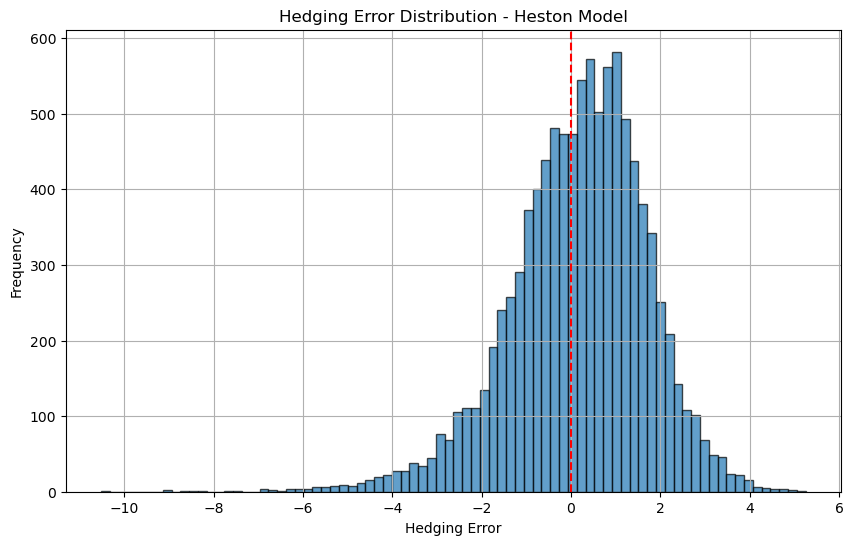

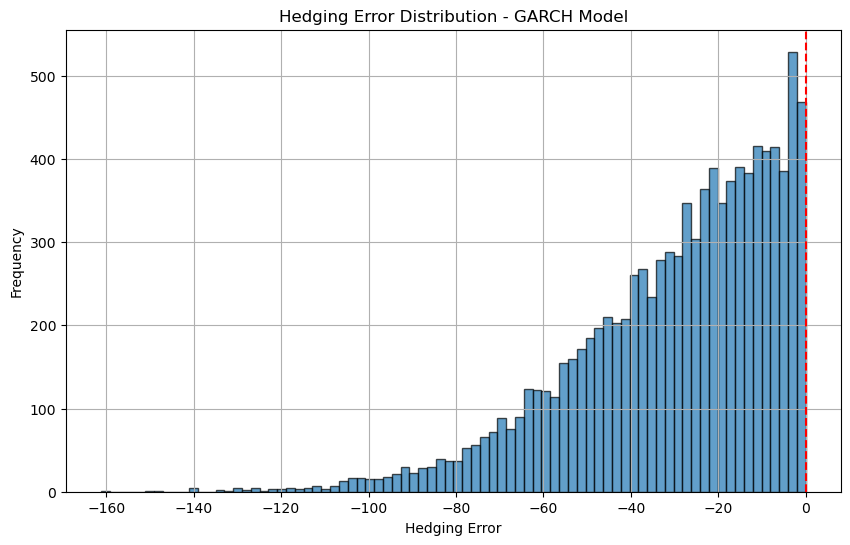

In [85]:
def plot_hedging_error_hist(errors, label):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=80, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Hedging Error Distribution - {label}")
    plt.xlabel("Hedging Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_hedging_error_hist(heston_errors, label="Heston Model")
plot_hedging_error_hist(garch_errors, label="GARCH Model")


#### Key Observations:
Black-Scholes delta hedging works reasonably well under the Heston model, where volatility is stochastic but mean-reverting.

Under the GARCH model, which captures volatility clustering and persistent shocks, hedging errors became large and consistently negative.

This outcome highlights the risk of model mis-specification: hedging with incorrect assumptions about volatility can lead to severe underhedging and financial loss.

To address this, we explore improved delta estimators that adapt to changing volatility.



#### Objective:  
Modify our delta hedging function to use the path-specific volatility at each time step — exactly what simulation produced.

Simulate GARCH Paths with Volatility Output

In [145]:
def simulate_garch_paths_with_vol(S0, mu, r, T, n_steps, alpha0, alpha1, beta1, n_paths=1000):
    dt = T / n_steps
    eps = np.random.normal(0, 1, (n_paths, n_steps))

    sigma2 = np.zeros((n_paths, n_steps + 1))
    sigma2[:, 0] = alpha0 / (1 - alpha1 - beta1)

    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    for i in range(n_steps):
        sigma2[:, i+1] = alpha0 + alpha1 * (eps[:, i]**2) + beta1 * sigma2[:, i]
        paths[:, i+1] = paths[:, i] * np.exp((mu - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i] * dt) * eps[:, i])

    return paths, sigma2


Compute Fair Option Price using GARCH MC

In [144]:
def garch_option_price_mc(S0, K, r, T, n_steps, alpha0, alpha1, beta1, n_paths=1000, option_type='call'):
    dt = T / n_steps
    eps = np.random.normal(0, 1, (n_paths, n_steps))

    sigma2 = np.zeros((n_paths, n_steps + 1))
    sigma2[:, 0] = alpha0 / (1 - alpha1 - beta1)

    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    for i in range(n_steps):
        sigma2[:, i+1] = alpha0 + alpha1 * (eps[:, i]**2) + beta1 * sigma2[:, i]
        paths[:, i+1] = paths[:, i] * np.exp((r - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i] * dt) * eps[:, i])

    final_prices = paths[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    else:
        payoffs = np.maximum(K - final_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


HedgingPortfolio Class



In [91]:
class HedgingPortfolio:
    def __init__(self, S0, option_price, r):
        self.cash = option_price
        self.stock = 0
        self.r = r
        self.update(S0, 0, 0)  # initialize with 0 delta

    def update(self, S, delta_new, dt):
        delta_change = delta_new - self.stock
        self.cash -= delta_change * S
        self.cash *= np.exp(self.r * dt)
        self.stock = delta_new

    def portfolio_value(self, S):
        return self.cash + self.stock * S


Black-Scholes Delta Function

In [93]:
def black_scholes_delta(S, K, tau, r, sigma, option_type='call'):
    if tau <= 0:
        return 1.0 if (option_type == 'call' and S > K) else 0.0

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return -norm.cdf(-d1)


Run Delta Hedging Using Pathwise Vol

In [94]:
def hedge_with_pathwise_vol(S_paths, sigma2_paths, K, r, T, option_price, option_type='call'):
    errors = []
    n_steps = S_paths.shape[1] - 1
    dt = T / n_steps

    for i in range(len(S_paths)):
        S_path = S_paths[i]
        sigma2_path = sigma2_paths[i]
        portfolio = HedgingPortfolio(S_path[0], option_price, r)

        for t in range(n_steps):
            tau = T - t * dt
            sigma_t = np.sqrt(sigma2_path[t])
            delta = black_scholes_delta(S_path[t], K, tau, r, sigma_t, option_type)
            portfolio.update(S_path[t], delta, dt)

        payoff = max(S_path[-1] - K, 0) if option_type == 'call' else max(K - S_path[-1], 0)
        error = portfolio.portfolio_value(S_path[-1]) - payoff
        errors.append(error)

    return np.array(errors)


In [95]:
# Parameters
S0 = 100
K = 100
r = 0.03
T = 1.0
n_steps = 252
n_paths = 10000
alpha0 = 1e-6
alpha1 = 0.1
beta1 = 0.85
mu = r

# Simulate paths
S_garch, sigma2_garch = simulate_garch_paths_with_vol(S0, mu, r, T, n_steps, alpha0, alpha1, beta1, n_paths)

# Get option price using GARCH Monte Carlo
option_price_garch = garch_option_price_mc(S0, K, r, T, n_steps, alpha0, alpha1, beta1, n_paths=10000)

# Run hedging with pathwise volatility
errors_garch_pathvol = hedge_with_pathwise_vol(S_garch, sigma2_garch, K, r, T, option_price_garch)


GARCH with Pathwise Volatility Hedging:
Mean Error: 1.0971
Std Dev  : 4.0241
Max Loss : -17.7890
Max Gain : 15.1455



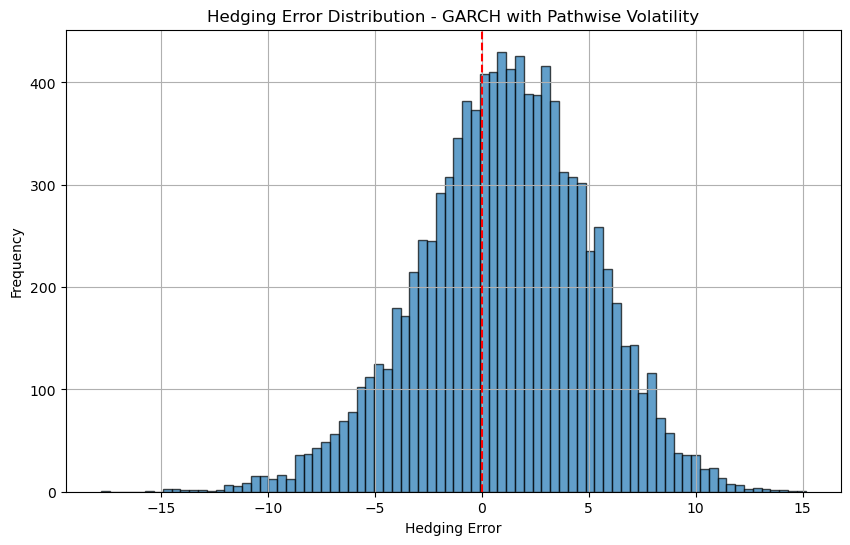

In [96]:
def print_summary(name, errors):
    print(f"{name} Hedging:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Std Dev  : {np.std(errors):.4f}")
    print(f"Max Loss : {np.min(errors):.4f}")
    print(f"Max Gain : {np.max(errors):.4f}\n")

import matplotlib.pyplot as plt

def plot_hedging_error_hist(errors, label):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=80, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Hedging Error Distribution - {label}")
    plt.xlabel("Hedging Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Print and plot
print_summary("GARCH with Pathwise Volatility", errors_garch_pathvol)
plot_hedging_error_hist(errors_garch_pathvol, label="GARCH with Pathwise Volatility")


GARCH Hedging Summary:
Using GARCH-based option pricing and pathwise volatility in delta hedging significantly reduced errors. The strategy now slightly overreplicates the payoff on average with much lower risk and more stable performance.

#### Heston Hedging with Pathwise Volatility
Now we implement delta hedging under the Heston model using:

- Monte Carlo option pricing under Heston dynamics
- Pathwise variance for delta computation at each hedge step

Simulate Heston Paths with Variance Output

In [143]:
def simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, n_steps, n_paths=1000):
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for i in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

        v[:, i+1] = np.abs(v[:, i] + kappa * (theta - v[:, i]) * dt + sigma_v * np.sqrt(v[:, i] * dt) * z2)
        S[:, i+1] = S[:, i] * np.exp((r - 0.5 * v[:, i]) * dt + np.sqrt(v[:, i] * dt) * z1)

    return S, v


Compute Option Price via Heston Monte Carlo

In [142]:
def heston_option_price_mc(S0, v0, kappa, theta, sigma_v, rho, r, T, K, n_steps, n_paths=1000, option_type='call'):
    S, _ = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, n_steps, n_paths)
    final_prices = S[:, -1]
    payoffs = np.maximum(final_prices - K, 0) if option_type == 'call' else np.maximum(K - final_prices, 0)
    return np.exp(-r * T) * np.mean(payoffs)


Run Hedging Using Pathwise Variance

In [103]:
def hedge_with_heston_vol(S_paths, v_paths, K, r, T, option_price, option_type='call'):
    errors = []
    n_steps = S_paths.shape[1] - 1
    dt = T / n_steps

    for i in range(len(S_paths)):
        S_path = S_paths[i]
        v_path = v_paths[i]
        portfolio = HedgingPortfolio(S_path[0], option_price, r)

        for t in range(n_steps):
            tau = T - t * dt
            sigma_t = np.sqrt(v_path[t])
            delta = black_scholes_delta(S_path[t], K, tau, r, sigma_t, option_type)
            portfolio.update(S_path[t], delta, dt)

        payoff = max(S_path[-1] - K, 0) if option_type == 'call' else max(K - S_path[-1], 0)
        error = portfolio.portfolio_value(S_path[-1]) - payoff
        errors.append(error)

    return np.array(errors)


In [104]:
# Heston Parameters
S0 = 100
K = 100
r = 0.03
T = 1.0
n_steps = 252
n_paths = 10000

v0 = 0.04
kappa = 2.0
theta = 0.04
sigma_v = 0.5
rho = -0.7

# Simulate Heston paths
S_heston, v_heston = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, n_steps, n_paths)

# Option price via Heston MC
option_price_heston = heston_option_price_mc(S0, v0, kappa, theta, sigma_v, rho, r, T, K, n_steps)

# Hedge with pathwise volatility
errors_heston_pathvol = hedge_with_heston_vol(S_heston, v_heston, K, r, T, option_price_heston)


Heston with Pathwise Volatility Hedging:
Mean Error: 0.1734
Std Dev  : 2.5483
Max Loss : -12.2074
Max Gain : 5.2216



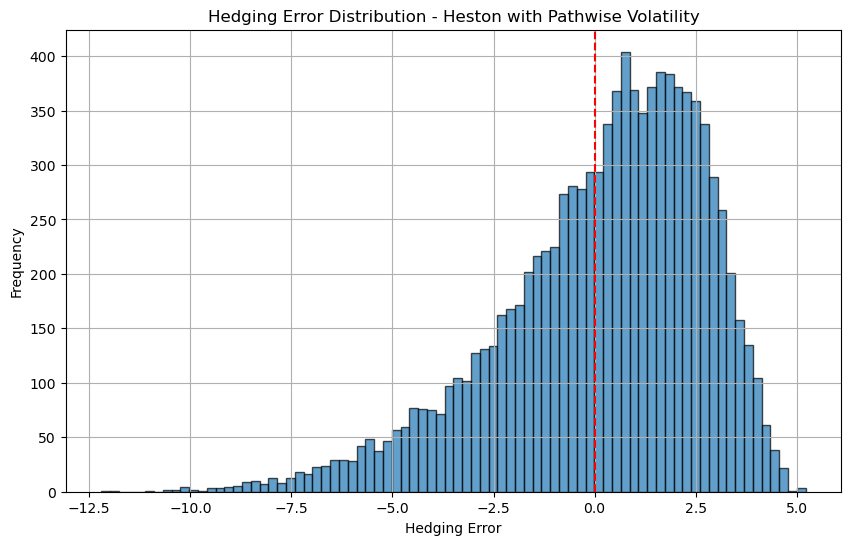

In [105]:
print_summary("Heston with Pathwise Volatility", errors_heston_pathvol)
plot_hedging_error_hist(errors_heston_pathvol, label="Heston with Pathwise Volatility")


Heston Hedging Summary:
Using Heston-based option pricing and pathwise variance led to stable but imperfect hedging. The Black-Scholes delta underrepresents volatility risk, limiting performance under stochastic variance. Results show moderate error, highlighting the need for more advanced hedging (e.g., vega hedge or model-consistent deltas).

### Conclusion
Under stochastic volatility models like GARCH and Heston, using pathwise volatility in delta estimation significantly reduces hedging error compared to naive constant-volatility assumptions. However, results also reveal that Black-Scholes delta alone cannot fully hedge options when volatility is itself dynamic—highlighting the need for more advanced techniques such as vega hedging or model-consistent delta strategies.



### Model-Consistent Delta Estimation via Monte Carlo Finite Differences.

##### General Delta Estimator Function

In [107]:
def model_delta_fd(price_func, S0, epsilon, *args, **kwargs):
    """
    Estimate model-consistent delta using central finite difference.

    Parameters:
    - price_func: function to compute option price under model
    - S0: initial spot price
    - epsilon: shift for finite difference
    - args, kwargs: additional arguments for price function

    Returns:
    - Finite difference delta estimate
    """
    price_plus = price_func(S0 + epsilon, *args, **kwargs)
    price_minus = price_func(S0 - epsilon, *args, **kwargs)
    return (price_plus - price_minus) / (2 * epsilon)


GARCH Delta via MC Finite Difference

In [116]:
epsilon = 0.05  # small shift in spot

# Wrap pricing function
garch_price_func = lambda S: garch_option_price_mc(
    S, K, r, T, n_steps, alpha0, alpha1, beta1, n_paths=50000, option_type='call'
)

# Compute delta
garch_delta_fd = model_delta_fd(garch_price_func, S0, epsilon)
print(f"GARCH Model-Consistent Delta: {garch_delta_fd:.4f}")


GARCH Model-Consistent Delta: -1.0528


Heston Delta via MC Finite Difference

In [117]:
# Wrap pricing function
heston_price_func = lambda S: heston_option_price_mc(
    S, v0, kappa, theta, sigma_v, rho, r, T, K, n_steps, n_paths=50000, option_type='call'
)

# Compute delta
heston_delta_fd = model_delta_fd(heston_price_func, S0, epsilon)
print(f"Heston Model-Consistent Delta: {heston_delta_fd:.4f}")


Heston Model-Consistent Delta: 1.2749


In [119]:
bs_delta = black_scholes_delta(S0, K, T, r, sigma=0.2, option_type='call')
print(f"Black-Scholes Delta: {bs_delta:.4f}")


Black-Scholes Delta: 0.5987


Now we will integrate the model-consistent deltas into our existing hedging simulation. We'll modify hedging function to use the finite-difference delta instead of Black-Scholes delta.

Define a Constant-Delta Hedging Function

In [132]:
def constant_delta_hedging(S_paths, K, r, T, initial_option_price, constant_delta, option_type='call'):
    """
    Hedging simulation using a fixed delta (e.g., model-consistent FD delta).

    Parameters:
    - S_paths: simulated paths (n_paths x n_steps+1)
    - constant_delta: the delta to use throughout the hedge
    """
    n_paths, n_steps = S_paths.shape
    dt = T / (n_steps - 1)
    errors = []

    for i in range(n_paths):
        S_path = S_paths[i]
        portfolio = HedgingPortfolio(S_path[0], initial_option_price, r)

        for t in range(n_steps - 1):
            portfolio.update(S_path[t], constant_delta, dt)

        # compare to option payoff
        final_S = S_path[-1]
        payoff = max(final_S - K, 0) if option_type == 'call' else max(K - final_S, 0)
        hedge_value = portfolio.portfolio_value(final_S)
        errors.append(hedge_value - payoff)

    return np.array(errors)


GARCH Hedging with FD Delta

In [133]:
# Simulate GARCH paths
S_garch = simulate_garch_paths(S0, mu=0.0, r=r, T=T, n_steps=n_steps,
                                  alpha0=alpha0, alpha1=alpha1, beta1=beta1,
                                  n_paths=5000)

# Use previously computed model-consistent delta
errors_garch_fd = constant_delta_hedging(S_garch, K, r, T,
                                         initial_option_price=garch_option_price_mc(
                                             S0, K, r, T, n_steps, alpha0, alpha1, beta1,
                                             n_paths=5000),
                                         constant_delta=garch_delta_fd)


Heston Hedging with FD Delta


In [134]:
# Simulate Heston paths
S_heston,__ = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho,
                                    r, T, n_steps, n_paths=5000)

# Use previously computed model-consistent delta
errors_heston_fd = constant_delta_hedging(S_heston, K, r, T,
                                          initial_option_price=heston_option_price_mc(
                                              S0, v0, kappa, theta, sigma_v, rho, r,
                                              T, K, n_steps, n_paths=5000),
                                          constant_delta=heston_delta_fd)


In [135]:
def print_summary(label, errors):
    print(f"{label}:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Std Dev  : {np.std(errors):.4f}")
    print(f"Max Loss : {np.min(errors):.4f}")
    print(f"Max Gain : {np.max(errors):.4f}")
    print("-" * 40)

print_summary("GARCH Hedging (FD Delta)", errors_garch_fd)
print_summary("Heston Hedging (FD Delta)", errors_heston_fd)


GARCH Hedging (FD Delta):
Mean Error: 7.0134
Std Dev  : 172.2260
Max Loss : -1899.9103
Max Gain : 142.2736
----------------------------------------
Heston Hedging (FD Delta):
Mean Error: -0.5682
Std Dev  : 16.7280
Max Loss : -99.4290
Max Gain : 22.7699
----------------------------------------


GARCH FD Delta: Unstable results. The standard deviation and losses are extreme. GARCH deltas are based on a path-dependent process where volatility reacts to recent price shocks, but we’re holding delta constant — this leads to large mismatch in hedge effectiveness. Also, the underlying variance is highly nonlinear in GARCH, so using one fixed delta is essentially a poor approximation.

Heston FD Delta:
More reasonable. Error distribution is wide, but within tolerable range. The mean error is small, and standard deviation is large but not catastrophic. Since Heston’s variance process is more stable (mean-reverting), fixed delta is more reliable.



##### Let’s now implement Dynamic Model-Consistent Delta Hedging using Monte Carlo finite differences. This means we will: Recompute the delta at each time step using small shifts in spot price under the current model state (GARCH or Heston).

##### Dynamic Finite-Difference Delta Function

In [162]:
def dynamic_fd_delta_batch(model_price_func, S_vec, epsilon, *args):
    """
    Vectorized FD delta for a batch of spot prices.
    """
    prices_up = np.array([model_price_func(S + epsilon, *args) for S in S_vec])
    prices_down = np.array([model_price_func(S - epsilon, *args) for S in S_vec])
    return (prices_up - prices_down) / (2 * epsilon)


Dynamic delta hedging simulation 

In [140]:
def dynamic_fd_delta_hedging_batched(S_paths, model_price_func, epsilon, K, r, T, dt,
                                      price_args=(), option_type='call'):
    """
    Optimized dynamic FD delta hedging using batched delta estimation.

    Parameters:
    - S_paths: shape (n_paths, n_steps+1)
    - model_price_func: function to price the option given spot S
    - epsilon: FD step size for delta
    - price_args: arguments passed to pricing function
    """
    n_paths, n_steps = S_paths.shape
    errors = []

    # Initial setup
    S0_vec = S_paths[:, 0]
    option_prices = np.array([model_price_func(S, *price_args) for S in S0_vec])
    portfolios = [HedgingPortfolio(S0_vec[i], option_prices[i], r) for i in range(n_paths)]

    # Hedging loop
    for t in range(n_steps - 1):
        S_t_vec = S_paths[:, t]
        deltas = dynamic_fd_delta_batch(model_price_func, S_t_vec, epsilon, *price_args)
        for i in range(n_paths):
            portfolios[i].update(S_t_vec[i], deltas[i], dt)

    # Final hedge error
    final_S = S_paths[:, -1]
    payoffs = np.maximum(final_S - K, 0) if option_type == 'call' else np.maximum(K - final_S, 0)
    hedge_vals = np.array([port.portfolio_value(final_S[i]) for i, port in enumerate(portfolios)])
    errors = hedge_vals - payoffs

    return np.array(errors)


Heston model

In [163]:
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.03        # Risk-free rate

# Heston parameters 
v0 = 0.04       # Initial variance (volatility^2 → 20% volatility)
kappa = 2.0     # Mean reversion speed
theta = 0.04    # Long-term variance (target ~20% vol)
sigma_v = 0.5   # Vol of volatility (vol-of-vol)
rho = -0.7      # Correlation between asset and volatility


n_steps = 252       # Daily steps (1 year)
n_paths = 500       #number of paths
n_paths_inner = 1000
epsilon = 0.1      # Step for FD delta
dt = T / n_steps

S_heston, _ = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, n_steps, n_paths)

# Use fewer inner paths for pricing
heston_price_func = lambda S: heston_option_price_mc(
    S, v0, kappa, theta, sigma_v, rho, r, T, K, n_steps, n_paths=n_paths_inner, option_type='call'
)

# Dynamic FD Delta Hedging (batched version)
errors_heston_dyn = dynamic_fd_delta_hedging_batched(
    S_heston, heston_price_func, epsilon=0.05, K=K, r=r, T=T, dt=dt
)



In [164]:
def print_summary(label, errors):
    print(f"{label}:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Std Dev  : {np.std(errors):.4f}")
    print(f"Max Loss : {np.min(errors):.4f}")
    print(f"Max Gain : {np.max(errors):.4f}")
    print("-" * 40)

print_summary("Dynamic Heston FD Delta Hedging", errors_heston_dyn)



Dynamic Heston FD Delta Hedging:
Mean Error: -1.2546
Std Dev  : 97.4206
Max Loss : -414.4151
Max Gain : 304.7238
----------------------------------------


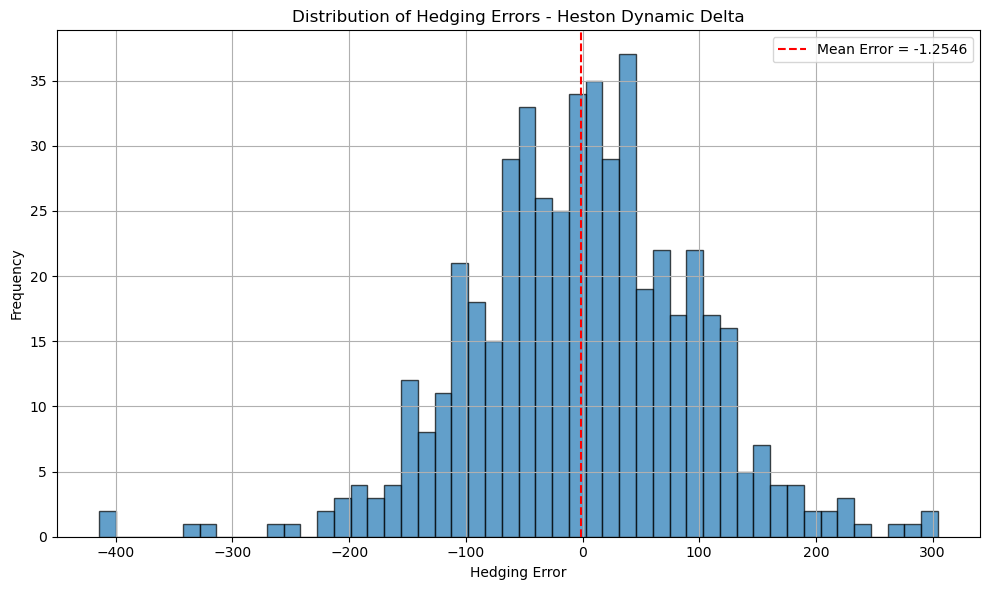

In [166]:
mean_error = np.mean(errors_heston_dyn)

# Histogram Plot 
plt.figure(figsize=(10,6))
plt.hist(errors_heston_dyn, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean Error = {mean_error:.4f}')
plt.title("Distribution of Hedging Errors - Heston Dynamic Delta")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The strategy resulted in a small average loss (mean error: -1.2546) and high variability (std: 97.42), indicating unstable performance. Large hedging errors suggest that finite-difference deltas under the Heston model may require more robust estimation or parameter tuning for reliability.



GARCH model

In [167]:
# GARCH Parameters
S0 = 100
K = 100
r = 0.03
T = 1.0
mu = 0.0  # Drift irrelevant under risk-neutral
alpha0 = 1e-5
alpha1 = 0.05
beta1 = 0.94

# Efficient Simulation Parameters
n_paths = 500        
n_steps = 252         
dt = T / n_steps
epsilon = 0.1       
n_paths_inner = 1000


# Simulate GARCH stock paths
S_garch = simulate_garch_paths(S0, mu, r, T, n_steps, alpha0, alpha1, beta1, n_paths)

# Pricing function 
garch_price_func = lambda S: garch_option_price_mc(
    S0=S, K=K, r=r, T=T, n_steps=n_steps,
    alpha0=alpha0, alpha1=alpha1, beta1=beta1,
    n_paths=n_paths_inner, option_type='call'
)

# Dynamic delta hedging using FD deltas
errors_garch_dyn = dynamic_fd_delta_hedging_batched(
    S_garch, garch_price_func, epsilon=epsilon, K=K, r=r, T=T, dt=dt
)


In [168]:
print_summary("Dynamic GARCH FD Delta Hedging", errors_garch_dyn)


Dynamic GARCH FD Delta Hedging:
Mean Error: 384.2422
Std Dev  : 6400.4843
Max Loss : -42344.6121
Max Gain : 83590.6626
----------------------------------------


In [171]:
mean_error_g = np.mean(errors_garch_dyn)
mean_error_g

np.float64(384.24217769835485)

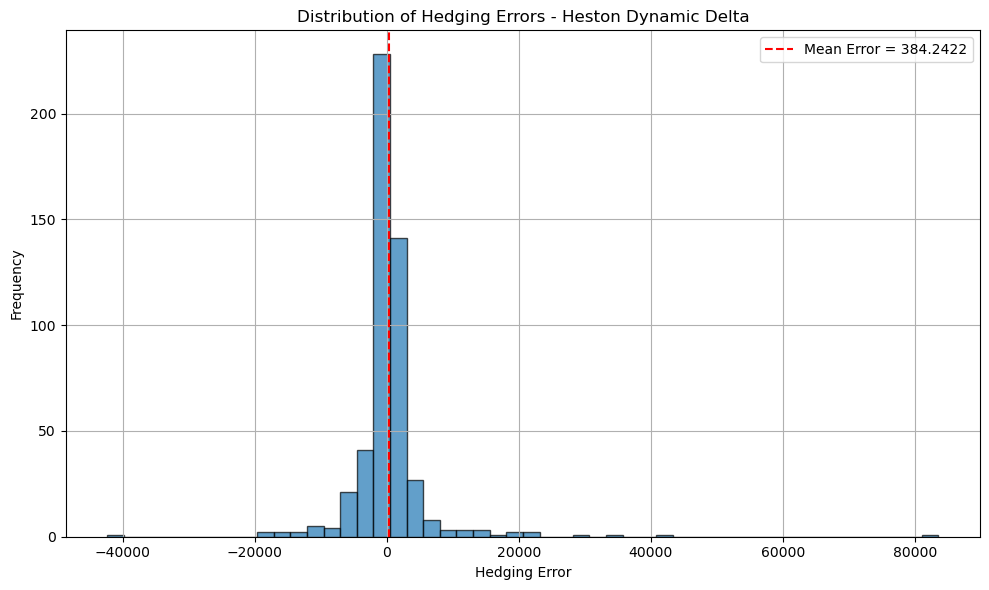

In [172]:
mean_error_g = np.mean(errors_garch_dyn)

# Histogram Plot 
plt.figure(figsize=(10,6))
plt.hist(errors_garch_dyn, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_error_g, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean Error = {mean_error_g:.4f}')
plt.title("Distribution of Hedging Errors - Heston Dynamic Delta")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The hedging strategy produced extremely high variability (std: 6400.48) and a large positive bias (mean error: 384.24), with significant tail risk. These results indicate that finite-difference deltas under the GARCH model are unstable, likely due to noisy option prices and path-dependent volatility dynamics. Further refinement in delta estimation or smoother approximation methods is needed.

## Dynamic Model-Consistent Delta Hedging

Dynamic hedging using model-consistent finite-difference deltas under the Heston and GARCH models revealed substantial performance gaps. While the Heston model showed moderate bias and high variance in hedging errors, the GARCH model exhibited severe instability with extreme tail risk and large mean deviations. These outcomes highlight the sensitivity of FD-based deltas to numerical noise, especially when volatility is stochastic and path-dependent. Enhancing stability—through better delta estimation, higher-quality pricing simulations, or alternative approximation methods—is essential for practical deployment.
